In [17]:
# Chemin du fichier YAML
yaml_file = "/Users/eartigau/bydoux/retraite_etienne.yaml"
#yaml_file = "/Users/eartigau/bydoux/retraite_myriam.yaml"

In [18]:
import yaml
from astropy.time import Time
import numpy as np

def impot_federal(revenu):
    """
    Calcule l'impôt fédéral pour l'année 2025
    en tenant compte du montant personnel de base.
    
    Paramètre:
        revenu (float) : revenu imposable brut
    
    Retour:
        float : impôt fédéral à payer
    """
    # Montant personnel de base non imposable
    montant_base = 15000
    
    # Revenu imposable après déduction du montant personnel
    revenu_imposable = max(0, revenu - montant_base)
    
    # Tranches d'imposition et taux pour 2025
    tranches = [57375 - montant_base, 114750 - 57375, 177882 - 114750, 253414 - 177882]  # ajustées après montant de base
    taux = [0.15, 0.205, 0.26, 0.29, 0.33]  # taux pour chaque tranche
    
    impot = 0
    reste = revenu_imposable
    
    # Calcul progressif
    for i, tranche in enumerate(tranches):
        if reste <= 0:
            break
        montant = min(reste, tranche)
        impot += montant * taux[i]
        reste -= montant
    
    # Si revenu dépasse la dernière tranche
    if reste > 0:
        impot += reste * taux[-1]
    
    return impot

def impot_quebec(revenu):
    """
    Calcule l'impôt provincial au Québec pour l'année 2025
    en tenant compte du montant personnel de base.
    
    Paramètre:
        revenu (float) : revenu imposable brut
    
    Retour:
        float : impôt provincial à payer
    """
    # Montant personnel de base non imposable
    montant_base = 17183
    
    # Revenu imposable après déduction du montant personnel
    revenu_imposable = max(0, revenu - montant_base)
    
    # Tranches d'imposition et taux pour 2025
    tranches = [53255 - montant_base, 106495 - 53255, 129590 - 106495]  # ajustées après montant de base
    taux = [0.14, 0.19, 0.24, 0.2575]  # taux pour chaque tranche
    
    impot = 0
    reste = revenu_imposable
    
    # Calcul progressif
    for i, tranche in enumerate(tranches):
        if reste <= 0:
            break
        montant = min(reste, tranche)
        impot += montant * taux[i]
        reste -= montant
    
    # Si revenu dépasse la dernière tranche
    if reste > 0:
        impot += reste * taux[-1]
    
    return impot

def rente_rrq(age_demande):
    """
    Calcule la rente annuelle maximale du RRQ selon l'âge de demande.
    
    age_demande : âge où vous réclamez la rente (entre 60 et 70 ans)
    
    Retour : rente annuelle en $
    """
    # Rente  à 65 ans en 2025
    rente_max_65 = 16775  # $ par an

    if age_demande < 60:
        age_demande=60

    # Ajustement selon âge de demande
    if age_demande < 65:
        mois_avant = (65 - age_demande) * 12
        ajustement = 1 - 0.006 * mois_avant  # 0,6% par mois avant 65
    elif age_demande > 65:
        mois_apres = (age_demande - 65) * 12
        ajustement = 1 + 0.007 * mois_apres  # 0,7% par mois après 65
    else:
        ajustement = 1.0

    rente_finale = rente_max_65 * ajustement
    return rente_finale


In [19]:
# Lecture du fichier YAML et conversion en dictionnaire Python
with open(yaml_file, "r", encoding="utf-8") as f:
    data = yaml.safe_load(f)

data['naissance_mjd'] = Time(data['date_de_naissance']).mjd
data['jour_mjd'] = Time.now().mjd
data['annee_courante'] =  Time(data['jour_mjd'],format='mjd').iso.split('-')[0]
data['annee_naissance'] = int(Time(data['naissance_mjd'],format='mjd').iso.split('-')[0])
data['age'] = int((data['jour_mjd']-data['naissance_mjd'])/365.24)
data['retraite_mjd'] = data['age_retraite']*365.24+data['naissance_mjd']

data['salaire_retraite'] = (1+data['augmentations'])**((data['retraite_mjd'] - data['jour_mjd'])/365.24)*data['salaire']

annee_fonds = [k for k in data['fonds_pension'].keys()]
val_fonds =  [data['fonds_pension'][k] for k in data['fonds_pension'].keys()]


inflation = data['inflation']['taux']


augmentation_rrq = (1+data['rrq']['taux_augmentation'])**((data['retraite_mjd'] - data['jour_mjd'])/365.24)

data['rente_rrq'] = rente_rrq(data['age_retraite'])*augmentation_rrq



retraite = np.interp(data['age_retraite'],annee_fonds, val_fonds)

retraite_total = retraite + data['rente_rrq'] + data['securite_vieillesse']['montant']



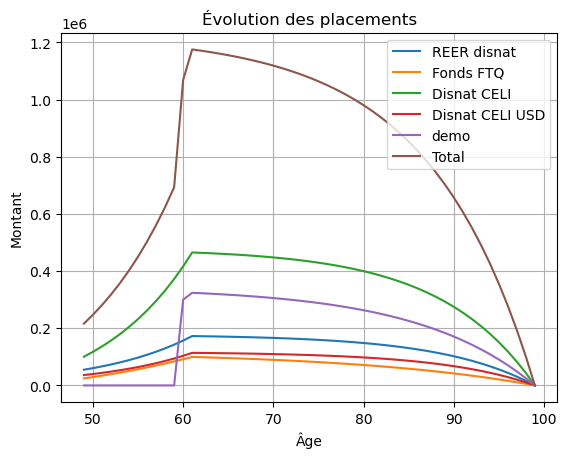

Type: CELI, Retrait optimal: 59493.24 $/an
CELI 59493.24252266386
Type: Non enregistré, Retrait optimal: 27390.62 $/an
Non enregistré 27390.615299392368
Type: REER, Retrait optimal: 23646.65 $/an
REER 23646.64946089672
Nom: Étienne
Rente RRQ: 16943.77$
Pension vieillesse: 12110.00$
Rente regime: 45814.00$
Retraite totale: 74867.77$
	 Age de la retraite: 62 ans
Total imposable : 74867.77 $
Impôt fédéral : 21018.43 $
Impôt provincial : 19824.09 $
Placement imposable : 51037.26 $
Placement non imposable : 59493.24 $
Total apres impot : 144555.76 $
Total par 2 semaines après impot : 5559.84 $


In [20]:

imposable = retraite_total*1.0
non_imposable = 0

from scipy.optimize import minimize
for key in data['placements']:

    def optim_retrait(retrait):
        montant = data['placements'][key]['montant']*1.0
        for yr in range(data['age'], data['age_mort']):
            # on s'occupe des REER
            montant *= (1 + data['placements'][key]['rendement'] - inflation)
            if 'cotisation_annuelle' in data['placements'][key]:
                if yr < data['age_retraite']:
                    montant += data['placements'][key]['cotisation_annuelle']

            if 'ajout_ponctuel' in data['placements'][key]:
                yr2 = (data['annee_naissance']+yr)
                if yr2 == data['placements'][key]['ajout_ponctuel']['annee']:
                    montant += data['placements'][key]['ajout_ponctuel']['montant']

            if (yr>=data['age_retraite']):
                if montant != 0:
                    montant -= retrait
        return np.abs(montant)

    result = minimize(optim_retrait, 0).x
    data['placements'][key]['retrait_optimal'] = result[0]

import matplotlib.pyplot as plt

all_val = 0

for key in data['placements']:
    montant = data['placements'][key]['montant']*1.0
    retrait = data['placements'][key]['retrait_optimal']
    yrs = []
    val = []
    for yr in range(data['age'], data['age_mort']):
        # on s'occupe des REER
        montant *= (1 + data['placements'][key]['rendement'] - inflation)
        if 'cotisation_annuelle' in data['placements'][key]:
            if yr < data['age_retraite']:
                montant += data['placements'][key]['cotisation_annuelle']

        if 'ajout_ponctuel' in data['placements'][key]:
            yr2 = (data['annee_naissance']+yr)
            if yr2 == data['placements'][key]['ajout_ponctuel']['annee']:
                montant += data['placements'][key]['ajout_ponctuel']['montant']

        if (yr>=data['age_retraite']):
            if montant != 0:
                montant -= retrait
        yrs.append(yr)
        val.append(montant)
    yrs = np.array(yrs)
    val = np.array(val)
    plt.plot(yrs, val, label=data['placements'][key]['description'])
    all_val+=val

plt.plot(yrs, all_val, label='Total')
plt.legend()
plt.xlabel('Âge')
plt.ylabel('Montant')
plt.title('Évolution des placements')
plt.grid()
plt.show()

# retrouver tous les data['placemenets'][key]['retrait_optimal']
# et tous les types

retrait_optimal_tous = np.array([data['placements'][key]['retrait_optimal'] for key in data['placements']])
types_tous = np.array([data['placements'][key]['type'] for key in data['placements']])

imposable_placement = 0
non_imposable_placement = 0

for utype in np.unique(types_tous):
    mask = (types_tous == utype)
    retrait_optimal_utype = np.sum(retrait_optimal_tous[mask])
    print(f"Type: {utype}, Retrait optimal: {retrait_optimal_utype:.2f} $/an")

    print(utype, retrait_optimal_utype)
    if 'CELI' in utype.upper():
        non_imposable_placement += retrait_optimal_utype
    else:
        imposable_placement += retrait_optimal_utype

impot_federal = impot_federal(imposable_placement+imposable)
impot_quebec = impot_quebec(imposable_placement+imposable)


print(f"Nom: {data['nom']}")
print(f"Rente RRQ: {data['rente_rrq']:.2f}$")
print(f"Pension vieillesse: {data['securite_vieillesse']['montant']:.2f}$")
print(f"Rente regime: {retraite:.2f}$")
print(f"Retraite totale: {retraite_total:.2f}$")


print(f'\t Age de la retraite: {data["age_retraite"]} ans')
print(f'Total imposable : {imposable:.2f} $')
print(f'Impôt fédéral : {impot_federal:.2f} $')
print(f'Impôt provincial : {impot_quebec:.2f} $')
print(f'Placement imposable : {imposable_placement:.2f} $')
print(f'Placement non imposable : {non_imposable_placement:.2f} $')

revenus_apres_impot = retraite_total + imposable_placement - impot_federal - impot_quebec + non_imposable_placement
print(f'Total apres impot : {revenus_apres_impot:.2f} $')
print(f'Total par 2 semaines après impot : {revenus_apres_impot/26:.2f} $')
